In [ ]:
#| default_exp datasets

In [1]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 fastai==2.7.11
!pip install tokenizers
!pip install torchdata==0.5.1

!pip install -Uqq git+https://github.com/fastai/course22p2 --cache-dir /content/drive/MyDrive/pip_cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 793.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/557.1 MB 103.5 MB/s eta 0:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 164.1 kB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone m

In [3]:
#|export
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

In [4]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
logging.disable(logging.WARNING)

## Hugging Face Datasets

In [7]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

In [8]:
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [9]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31049107.0, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5192560.0, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [10]:
dsd = load_dataset(name)
dsd

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [11]:
train,test = dsd['train'],dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [12]:
x,y = ds_builder.info.features

In [13]:
x,y

('image', 'label')

In [14]:
x,y = 'image','label'
img = train[0][x]
img

In [15]:
label = train[0][y]
label

9

In [16]:
xb = train[:5][x]
yb = train[:5][y]
yb,xb

([9, 0, 0, 3, 0],
 [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>])

In [17]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [18]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [19]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [20]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}
def collate_fn(b):
  return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
          y:tensor([o[y] for o in b])}

In [21]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [22]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [24]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y],b[y].shape

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]),
 torch.Size([16]))

In [25]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]#每一个o都展平后进行存储

In [26]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [27]:
transformi = inplace(_transformi)

In [31]:
r = train.with_transform(transformi)[0]
len(r[x])

784

In [34]:
r = train.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [35]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [36]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [37]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')#itemgetter接受一个或多个参数并返回一个函数
ig(d)#传入一个字典

(1, 3)

In [38]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [39]:
d = D()
ig(d)

(1, 3)

In [40]:
list(tdsf.features)

['image', 'label']

In [41]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [44]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

def collate_dict(ds):
  get = itemgetter(*ds.features)#input'image','label'
  def _f(b):  return get(default_collate(b))#返回batchsize大小的数据
  return _f

In [45]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

## Plotting images

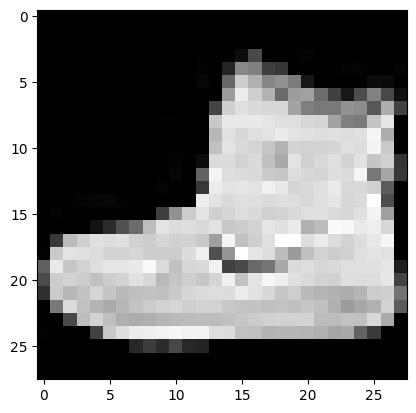

In [54]:
b = next(iter(dl))#the batchsize of dl is 16
xb = b['image']
img = xb[0]
plt.imshow(img[0])

In [56]:
yb = b['label']
xb.shape,yb

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [57]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)#三通道则要转换为hwc才能显示
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax

In [58]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



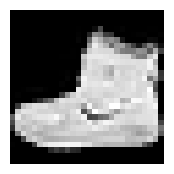

In [62]:
show_image(img, figsize=(2,2));

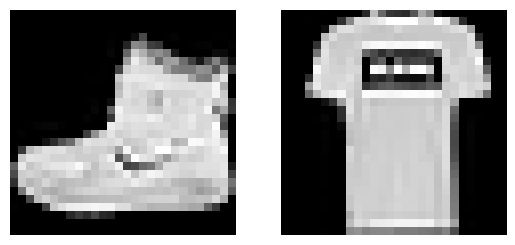

In [64]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [65]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

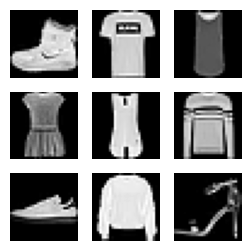

In [77]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:9]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [78]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

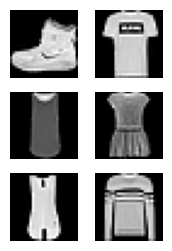

In [85]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [86]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [87]:
yb = b['label']
lbls = yb[:8]

In [88]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

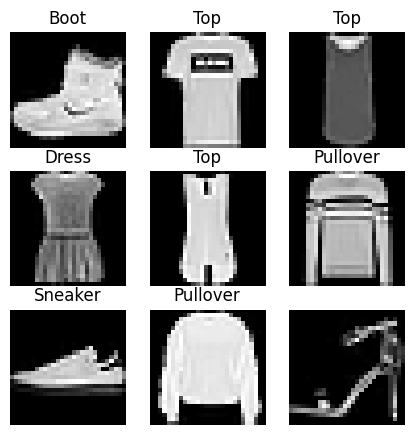

In [89]:
show_images(imgs, imsize=1.7, titles=titles)

In [90]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()